In [ ]:
# libs needed that aren't on the huggingface container 
# !pip install datasets --user
# ! pip install evaluate --user

In [1]:
import csv
import pandas as pd
from transformers import BertTokenizerFast, TrainingArguments, Trainer, BertForSequenceClassification, \
    DataCollatorWithPadding
from datasets import Dataset, load_dataset, DatasetDict
import csv
import pandas as pd
from sklearn import model_selection
import torch
import evaluate
import numpy as np

In [9]:
with open('Tweets.csv', mode='r') as file:
    df = pd.read_csv(file, header=0)
    df = df.drop(columns=['textID', 'selected_text'], axis=1)
    df = df.rename(columns={"text": "texts", "sentiment": "label"})
    df = df.dropna()

df['label'] = df['label'].replace({"neutral":1, "negative":0, "positive":2})


dataset = Dataset.from_pandas(df)
train_test_valid = dataset.train_test_split(test_size=0.2)
# this is apparently the best way to create a validation set
# shuffle defaults to true
test_valid = train_test_valid['test'].train_test_split(test_size=0.8)
dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
print(dataset)
print(dataset["train"][0])


DatasetDict({
    train: Dataset({
        features: ['texts', 'label', '__index_level_0__'],
        num_rows: 21984
    })
    test: Dataset({
        features: ['texts', 'label', '__index_level_0__'],
        num_rows: 4397
    })
    valid: Dataset({
        features: ['texts', 'label', '__index_level_0__'],
        num_rows: 1099
    })
})
{'texts': 'Don`t let the sun catch you crying - Oh my.. so cool  http://tinyurl.com/cugy8c', 'label': 2, '__index_level_0__': 21558}


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def tokenize_function(example):
    """
    Tokenizes input embeddings using model tokenizer"""
    return tokenizer(example["texts"], truncation=True)

metric1 = evaluate.load("precision")
metric2 = evaluate.load("recall")
    
def compute_metrics(eval_preds):
    """
    Computes eval metrics"""
    
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels, average="weighted")
    recall = metric2.compute(predictions=predictions, references=labels, average="weighted")
    

    cm = confusion_matrix(predictions, labels)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return {"precision": precision, "recall": recall}

# tokenize input sequences to subwords
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenized_tweets = dataset.map(tokenize_function, batched=True)


# for batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/4397 [00:00<?, ? examples/s]

Map:   0%|          | 0/1099 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


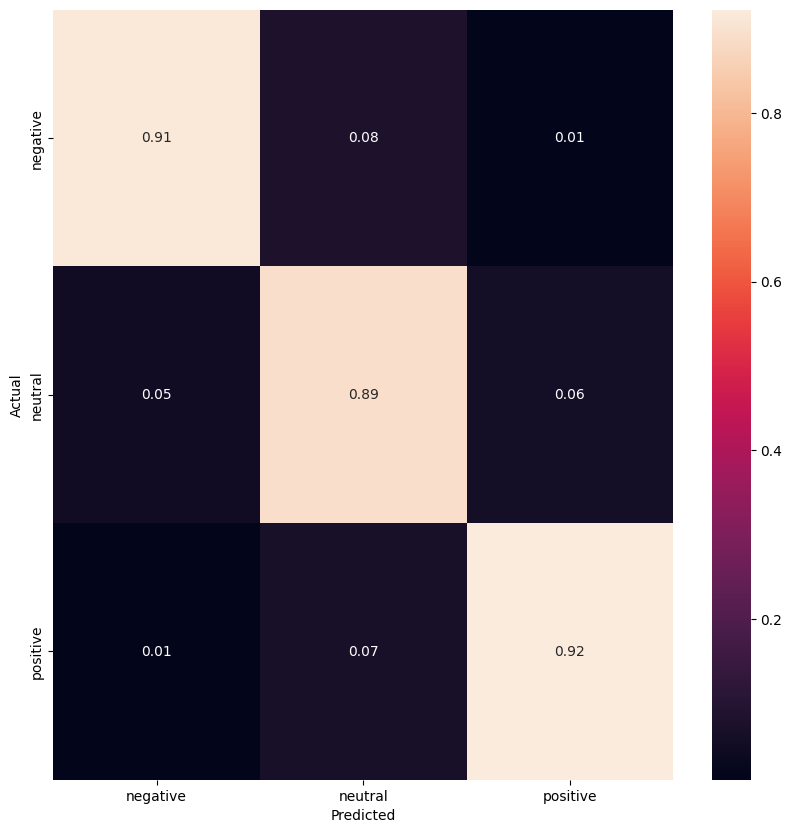

Trainer is attempting to log a value of "{'precision': 0.9072238048595989}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9072094609961338}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.2903690040111542, 'eval_precision': {'precision': 0.9072238048595989}, 'eval_recall': {'recall': 0.9072094609961338}, 'eval_runtime': 7.5234, 'eval_samples_per_second': 584.445, 'eval_steps_per_second': 9.836}


In [32]:
# to load from checkpoint for eval; trainer class takes care of both training and eval.
# pretty much just a general model wrapper
model = BertForSequenceClassification.from_pretrained('results/')

args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=30
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    eval_dataset=tokenized_tweets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# speeds up testing by turning off backprop objects
with torch.no_grad():
    eval_results = trainer.evaluate()
print(eval_results)

In [4]:
# to train model; see https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification
import torch
print(tokenized_tweets)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())

# init model:
# takes in a string and pulls the model from huggingface
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01)

# train
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_tweets["train"],
    eval_dataset=tokenized_tweets["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model()

DatasetDict({
    train: Dataset({
        features: ['texts', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21984
    })
    test: Dataset({
        features: ['texts', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4397
    })
    valid: Dataset({
        features: ['texts', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1099
    })
})
True
cuda
2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss
500,0.685800
1000,0.542400
1500,0.488300
2000,0.407000
2500,0.405800
3000,0.336700
3500,0.274900
4000,0.290700


/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqu

In [9]:
with torch.no_grad():
    eval_results = trainer.evaluate(tokenized_tweets["test"])
print(eval_results)

/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].